In [1]:
# Import all the libraries
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.
pd.set_option('display.max_columns', None)
import glob
import datetime
import os
import json
from io import StringIO
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
%matplotlib inline

### Sampling and loading the data
For this exploratory analysis we used the Spark cluster to randomly sample the data with the `sample_data.py` script and retrieved the metadata entries for the items that appear in our samples by writing the product IDs to a text file one per line and using the `get_metadata.py` script.

In [2]:
# Paths to the data and metadata folders.
DATA_FOLDER = 'data/'
META_FOLDER = DATA_FOLDER + 'meta/'

In [3]:
# Load one data file
def load_one_file(path):
    with open(path) as f:
        return [json.loads(line) for line in f]

# Load one metadata file. The rows aren't proper JSON
# but they can be parsed using python's eval function
# as per the dataset's web page.
def load_one_meta_file(path):
    with open(path) as f:
        return [eval(line) for line in f]

# The sample we extracted is still too large, so we'll only use the first 100 files
data_files = glob.glob(DATA_FOLDER + 'part-000*')
data = sum(map(load_one_file, data_files), [])

# Create the first dataframe
df = pd.DataFrame(data)

# Write the product IDs to a .csv files, one per line.
# Used to get metadata using the cluster.
# df[['asin']].to_csv('asin_lookup.csv', index=False, header=False)

# The meta folder contains metadata for all the items we were interested in.
meta_files = glob.glob(META_FOLDER + '*')
meta = sum(map(load_one_meta_file, meta_files), [])

# Create the second dataframe
meta_df = pd.DataFrame(meta)

In [4]:
# Join the dataframes. Since our analysis relies on the metadata for a good part
# we have to remove any reviews for which metadata is not available.
joined = pd.merge(df, meta_df, how='inner')

# Parse the review time as a DateTime and add review month and year columns
joined['reviewTime'] = pd.to_datetime(joined.unixReviewTime, unit='s')
joined['reviewMonth'] = joined.reviewTime.map(lambda t: t.month)
joined['reviewYear'] = joined.reviewTime.map(lambda t: t.year)

# We don't want any reviews for which the price is either NaN or 0
# or which don't belong to any category
joined = joined.dropna(axis=0, subset=['categories', 'price', 'reviewText'])
joined = joined[joined.price != 0 & (len(joined.reviewText) > 0)]

### Adding features
#### Sentiment scores
Thre are several options to do sentiment analysis: clustering, training a classifier on an existing corpus of labeled data or using a pre-trained one. We used [VADER](https://github.com/cjhutto/vaderSentiment), a pre-trained sentiment score analyzer tuned for messages that tipically appear on social media to give each review text a series of sentiment scores. The reasons behind our choice are that training a classifirer is time consuming and that VADER is trained on text snippets similar to those in our dataset, including some from Amazon reviews.

In [5]:
analyzer = SentimentIntensityAnalyzer()

# Example
print(joined.iloc[10]['reviewText'])
analyzer.polarity_scores(joined.iloc[10]['reviewText'])

So creative and funny. Loved the many twists and turns of this story and the clever way in which the author wove history into the craziness that was this man's life!


{'compound': 0.899, 'neg': 0.062, 'neu': 0.617, 'pos': 0.321}

In [6]:
# Add the sentiment score columns to the dataframe
comp_score = joined.reviewText.apply(lambda t: analyzer.polarity_scores(t))
joined['compound_score'] = comp_score.apply(lambda s: s['compound'])
joined['positive_score'] = comp_score.apply(lambda s: s['pos'])
joined['negative_score'] = comp_score.apply(lambda s: s['neg'])
joined['neutral_score'] = comp_score.apply(lambda s: s['neu'])

In [7]:
# Each non-empty sales rank is a dictionary that maps exactly one
# category to exactly one ranking
joined['salesRankPosition'] = joined.salesRank.apply(lambda r: list(r.values())[0]
                                                     if r and isinstance(r, dict) else np.nan)
joined['salesRankCategory'] = joined.salesRank.apply(lambda r: list(r.keys())[0]
                                                     if r and isinstance(r, dict) else np.nan)

#### Word counts
We measured the number of words that make up a review as an indicator of the review's complexity.

In [8]:
# Word tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Add tokenized text and word cound to the dataframe
joined['tokenized_text'] = joined.reviewText.apply(tokenizer.tokenize)
joined['word_count'] = joined.tokenized_text.apply(len)

#### Main category
Each item in the dataset has a `categories` field which, when not absent, is an array of arrays of strings. Each item can belong to an arbitrary number of categories some of which are subcategories of a larger category. We will first flatten these arrays of arrays in order to make subsequent processing easier.

In [9]:
# Flatten the categories
joined['categories_flat'] = joined.categories.apply(lambda a: [i for sa in a for i in sa])
# Remove rows with no categories
joined = joined[[(c and bool(c[0])) for c in joined.categories_flat]]

In order to be able to plot aggregate values for each category we need to pick one category for each product that we will use as its main category. We built a dictionary that maps the most common categories to the main category and assigned a main category to each item according to which of these common categories it belongs to. In order to build this dictionary we started from the list of categories that the maintainer of the dataset offers separate files for and added more until we could cover almost all the items.

In [10]:
# Load category dictionary from file
categories_dict = None
with open('categories_dict.json') as f:
    categories_dict = json.load(f)

In [11]:
# Function that returns an item's main category according
# to the above dictionary, or NaN if none of its categories appear in the dictionary.
def get_main_category(categories):
    for c in categories:
        if c in categories_dict:
            return categories_dict[c]

    return np.nan

# Derive each product's main category
joined['main_category'] = joined.categories_flat.apply(lambda a: get_main_category(a))

# Remove items for which there is no category
joined = joined.dropna(axis=0, subset=['main_category'])

Even though this is not explained in the dataset's documentation we can see that in all but one review the second element of the `helpful` field is greater or equal than the first. Thus we assume that the first element is the number of users that rated the review as helpful and the second one is the total number of ratings that the review received.

In [12]:
# Number of times that the review was voted as helpful
joined['helpful_pos'] = joined.helpful.apply(lambda a: a[0])

# Total number of votes that the review received
joined['helpful_tot'] = joined.helpful.apply(lambda a: a[1])

# Ratio of helpful votes to total votes
joined['helpful_ratio'] = joined.helpful.apply(lambda a: a[0] / a[1] if a[1] else np.nan)

We split the prices in tiers to run some of the comparisons.

In [13]:
# Arbitrarily chosen
price_bins = [
    0,
    10,
    20,
    30,
    40,
    50,
    60,
    70,
    80,
    90,
    100,
    200,
    500,
    1000
]

joined['price_tier'] = pd.cut(joined.price, price_bins)

In [14]:
# Final dataframe
joined.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,brand,categories,description,imUrl,price,related,salesRank,title,reviewMonth,reviewYear,compound_score,positive_score,negative_score,neutral_score,salesRankPosition,salesRankCategory,tokenized_text,word_count,categories_flat,main_category,helpful_pos,helpful_tot,helpful_ratio,price_tier
2,B00E7OIOVC,"[0, 0]",5.0,Great!,2014-07-03,A0001528BGUBOEVR6T5U,igozingo,Five Stars,1404345600,niceEshop,"[[Home & Kitchen, Kitchen & Dining, Kitchen Ut...",Style flask funnel great to help you fill your...,http://ecx.images-amazon.com/images/I/31gMKQdA...,1.99,"{'also_bought': ['B004TQIB7U', 'B006O1EBHW', '...",{'Kitchen & Dining': 63021},niceEshop(TM) Small Stainless Steel Funnel For...,7,2014,0.6588,1.000,0.000,0.000,63021.0,Kitchen & Dining,[Great],1,"[Home & Kitchen, Kitchen & Dining, Kitchen Ute...",Home & Kitchen,0,0,NaN,"(0, 10]"
3,B00EXOZ9W8,"[0, 0]",5.0,"My man was more then happy with it, looking fo...",2014-07-02,A00030342K9JCQO8Q7C3L,Joseph Dvorak,Five Stars,1404259200,NaN,"[[Home & Kitchen, Kitchen & Dining, Small Appl...",,http://ecx.images-amazon.com/images/I/41Oc0HaP...,65.81,"{'also_bought': ['B000FAJ0K6', 'B0012UY6XO', '...",{'Kitchen & Dining': 56153},BELLA 14025 Programmable Slow Cooker with Lock...,7,2014,0.7893,0.349,0.000,0.651,56153.0,Kitchen & Dining,"[My, man, was, more, then, happy, with, it, lo...",14,"[Home & Kitchen, Kitchen & Dining, Small Appli...",Home & Kitchen,0,0,NaN,"(60, 70]"
4,1477473939,"[0, 0]",4.0,Reading this seriers was a amazing. It was ver...,2013-01-26,A000443821AD43TOGKNGZ,Uluwehi,Really enjoyed it!,1359158400,NaN,[[Books]],USA Today Best Selling Author Elizabeth Reyes...,http://ecx.images-amazon.com/images/I/51bhuPCO...,4.99,"{'also_bought': ['147522186X', '1475244207', '...",{'Books': 1011147},Making You Mine: The Moreno Brothers,1,2013,0.9199,0.353,0.000,0.647,1011147.0,Books,"[Reading, this, seriers, was, a, amazing, It, ...",31,[Books],Books,0,0,NaN,"(0, 10]"
5,1477473939,"[0, 0]",4.0,"I haven't read any of this series before, but ...",2013-04-09,A1BAWRQQMC7L72,Roswellfan410,Really liked it,1365465600,NaN,[[Books]],USA Today Best Selling Author Elizabeth Reyes...,http://ecx.images-amazon.com/images/I/51bhuPCO...,4.99,"{'also_bought': ['147522186X', '1475244207', '...",{'Books': 1011147},Making You Mine: The Moreno Brothers,4,2013,0.9548,0.411,0.000,0.589,1011147.0,Books,"[I, haven, t, read, any, of, this, series, bef...",35,[Books],Books,0,0,NaN,"(0, 10]"
6,B0092QSQ3Q,"[0, 0]",5.0,It is really good! But it was hard to push out...,2012-11-03,A00044782UB564I4SGA0X,Johan98,Really good!,1351900800,NaN,"[[Cell Phones & Accessories, Accessories, Scre...",Protect your InvestmentDaily use of your mobil...,http://ecx.images-amazon.com/images/I/51722Hcw...,5.95,"{'also_bought': ['B00FDXLRM4', 'B009VO0506', '...",{'Cell Phones & Accessories': 4377},Skinomi&reg; TechSkin - Apple iPhone 5 Screen ...,11,2012,0.6534,0.228,0.056,0.716,4377.0,Cell Phones & Accessories,"[It, is, really, good, But, it, was, hard, to,...",22,"[Cell Phones & Accessories, Accessories, Scree...",Electronics,0,0,NaN,"(0, 10]"


In [15]:
# See how many reviews are left
print('Remaining reviews: {}'.format(joined.shape[0]))

Remaining reviews: 125958


### Error bars with bootstrap resampling
When plotting aggregate statistics for a group, such as the mean score, we need to include error bars in the plot. We used bootstrap resampling to derive confidence intervals for those statistics since the underlying distribution of the data is unknown to us in general.

All the error bars that we used in our analysis are 95% confidence intervals obtained using this method.

In [16]:
def bootstrap_estimate(data, func):
    """Calculate a bootstrap estimate of a certain function of a sequence
    This function draws a random sample with replacement from a list and
    uses func to calculate a statistic over that sample.
    Since the sample is drawn with replacement each element of the list
    may appear multiple times or not appear at all in the sample.
    """
    n = len(data)
    
    # Generate n random indices with replacement
    indices = np.random.randint(n, size=n)
    
    # Sample the data
    sample = data.iloc[indices]

    # Compute the statistic
    return func(sample)

def confidence_interval(data, count, func, confidence=0.95):
    """Return a statistic and its confidence interval of a sequence using bootstrap resampling.
    Computes the statistic over count bootstrap samples drawn from the data, then computes the 
    lower and uppper bounds of the confidence interval.
    """
    estimates = [bootstrap_estimate(data, func) for _ in range(count)]
    
    # Debug: verify that the estimates have a normal distribution
    # plt.hist(estimates, bins=50)
    
    # Calculate the confidence interval bounds assuming a normal distribution in
    # the estimates
    m, se = np.mean(estimates), np.std(estimates)
    lower, upper = scipy.stats.norm.interval(confidence, loc=m, scale=se)
    
    return m, lower, upper

def plot_groupby_error_bars(grouped, count, func, ax, confidence=0.95):
    """Plot a bar plot showing the result of a statistic applied to the groups
    of a groupby object and use count bootstrap samples to compute confidence intervals
    """
    out = grouped.agg(lambda a: confidence_interval(a, count, func, confidence))
    means = out.apply(lambda x: x[0] if x else 0)
    mins = out.apply(lambda x: x[1] - x[0] if x else 0)
    maxs = out.apply(lambda x: x[2] - x[0] if x else 0)

    errs = np.c_[mins, maxs].T
    means.plot(kind='bar', ax=ax, yerr=errs, ecolor='r')

In [17]:
# Example: 95% confidence interval of the mean of the review scores with
# 1000 bootstrap samples. 
confidence_interval(joined.overall, 1000, np.mean)

(4.1892369837564907, 4.1824896948033885, 4.1959842727095928)

### Feature analysis
We can now start to have a look at the distribution of the various features. First of all: overall score distribution.

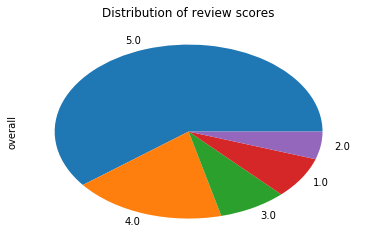

In [18]:
# Overall distribution
joined.overall.value_counts().plot(kind='pie', title='Distribution of review scores')

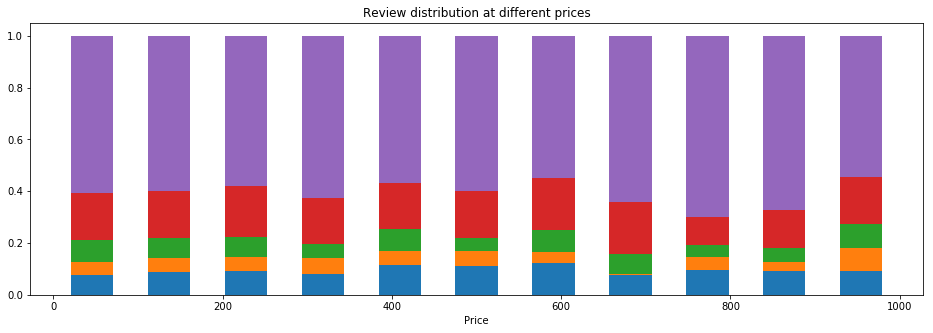

In [19]:
# Distribution with respect to price
_, ax1 = plt.subplots(1, 1, figsize=(16,5))
ax1.set_title('Review distribution at different prices')
ax1.set_xlabel('Price')

# Divide the reviews in uniformly sized bins according to the item's price
bins = np.linspace(0, 1000, 12)
gb = joined.groupby('overall')
series = np.array([np.histogram(gb.get_group(i).price.values, bins=bins)[0] for i in range(1, 6)])

# Make the total height of the bars equal 1
series = series / series.sum(axis=0)
histbins = bins[:-1] + np.ediff1d(bins) / 2
bottom = np.zeros(series.shape[1])

for i in range(series.shape[0]):
    ax1.bar(histbins, series[i], width=50, bottom=bottom)
    bottom += series[i]

We can see that more than half of the reviews gave five stars to the product independently of the price. The low proportion of 1 and 2 star reviews suggests that customers are very likely to be satisfied with the product they purchased.

Let's now consider the number of reviews by month of the year.

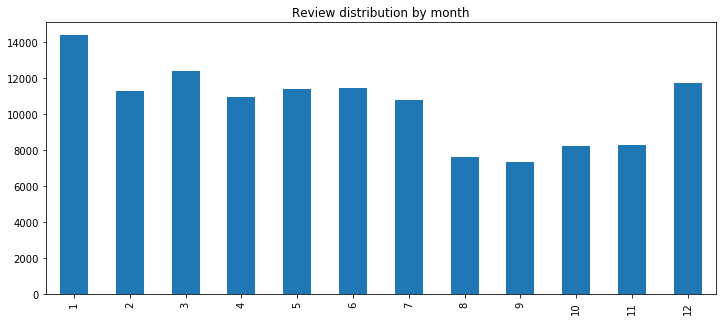

In [20]:
_, ax = plt.subplots(figsize=(12,5))
joined.reviewMonth.value_counts().sort_index().plot(ax=ax, kind='bar', title='Review distribution by month')

The number of reviews seems to be highest during winter and spring and lower during autumn, with January being the month with the highest number of reviews. The biggest shopping time in the year is during the christmas holidays and we imagine that reviews are written the next month after the product has been used for some time.

We can now start looking at the prices of the items.

In [21]:
# Group the items by price tier
group_by_price_tier = joined.groupby('price_tier')

First of all we can plot the distribution of the prices of reviewed items.

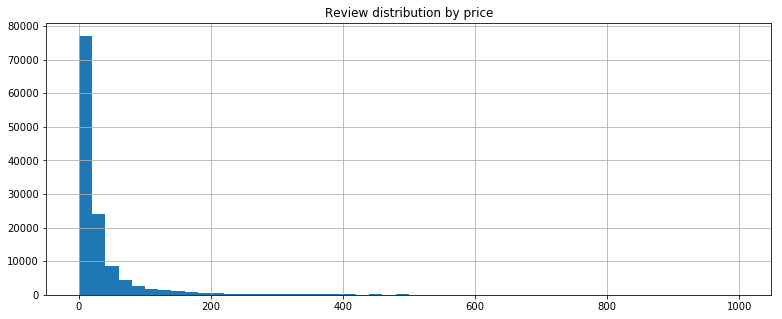

In [22]:
_, ax = plt.subplots(figsize=(13,5))
ax.set_title('Review distribution by price')
joined.price.hist(bins=50, ax=ax)

The distribution seems to be heavy tailed, with very cheap items making up the majority of the reviews. We can verify if this distribution follows a power law by plotting it on a log-log scale.

In [23]:
# We need to make logarithmic bins ourselves.
# _, ax = plt.subplots(figsize=(13,5))

# ax.set_xscale('log')
# ax.set_title('Review distribution by price')
# joined.price.hist(ax=ax, log=True, bins=log_bins)

The distribution doesn't follow a linear relationship on a log-log plot so the distribution is not a power law.

Now let's see the distribution according to the price tiers we defined above.

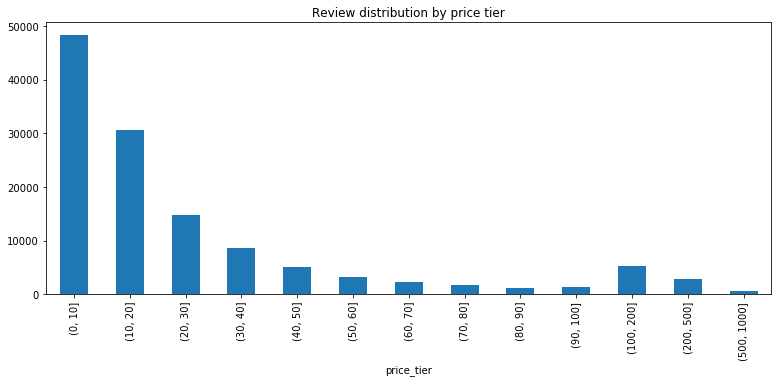

In [24]:
_, ax = plt.subplots(figsize=(13,5))

ax.set_title('Review distribution by price tier')

group_by_price_tier.size().plot(kind='bar', ax=ax)

One of the hypotheses we want to verify is whether the price of an item correlates with its review score, more specifically whether items belonging to a higher price tier are more likely to get better reviews. We can verify that by computing the mean review score for each price tier and displaying that on a bar plot.

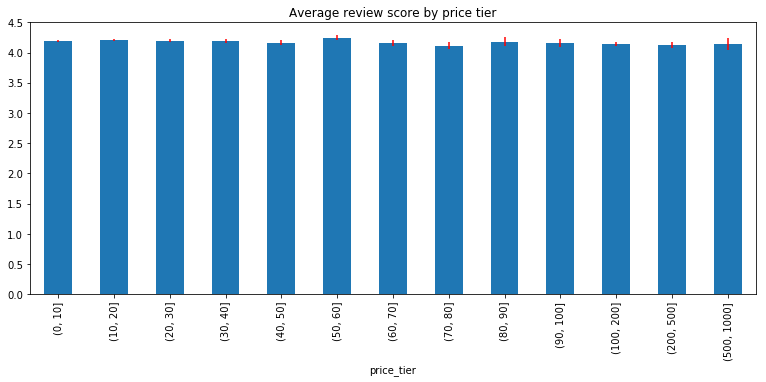

In [25]:
_, ax = plt.subplots(figsize=(13,5))

ax.set_title('Average review score by price tier')

plot_groupby_error_bars(group_by_price_tier.overall, 1000, np.mean, ax=ax)

There seems to be no correlation between an item's price tier and its mean score. We did not look at the medians since more than half of the reviews give 5 stars to the item in all price tiers and thus the median would always be 5.

We can also verify whether the month during which a review was written correlates with its score. The presence of such a correlation could indicate that buyers are more likely to give a better review in certain periods of the year than others.

In [26]:
# Group data by the month in which the review was written.
group_by_month = joined.groupby('reviewMonth')
overall_month = group_by_month.overall

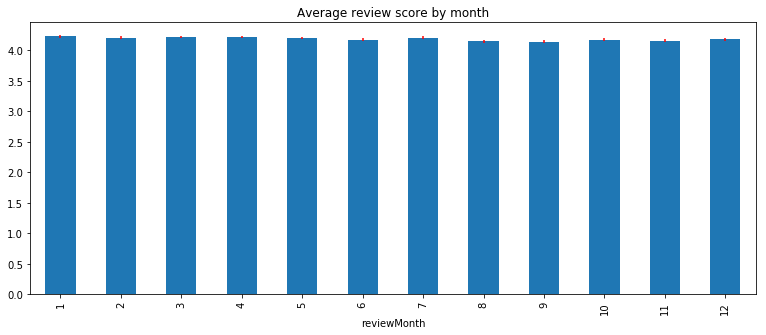

In [27]:
_, ax = plt.subplots(figsize=(13,5))
ax.set_title('Average review score by month')

plot_groupby_error_bars(overall_month, 1000, np.mean, ax)

Again, we can see that the correlation we hypothesized does not exist in the data. The review scores seem to be independent of the month in which they were written.

Let's now look at the items grouped by their category

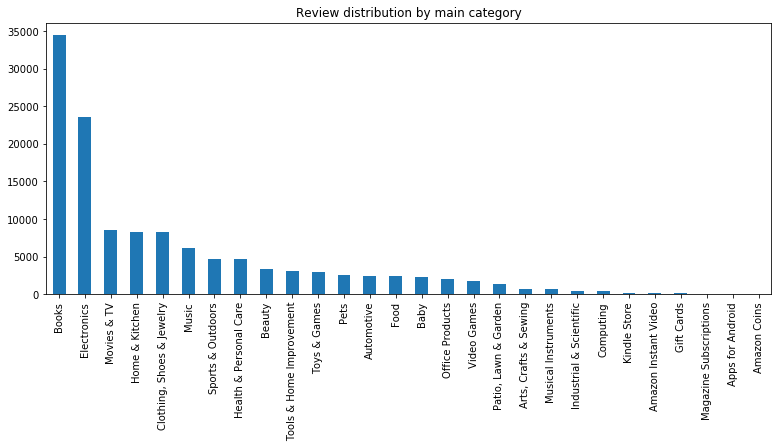

In [28]:
_, ax = plt.subplots(figsize=(13,5))
ax.set_title('Review distribution by main category')

joined.main_category.value_counts().plot(kind='bar', ax=ax)

In [29]:
pd.DataFrame({
    'All reviews': joined.main_category.value_counts(),
}).sort_values('All reviews', ascending=False)

,All reviews
Books,34391
Electronics,23594
Movies & TV,8488
Home & Kitchen,8340
"Clothing, Shoes & Jewelry",8326
Music,6197
Sports & Outdoors,4747
Health & Personal Care,4640
Beauty,3404
Tools & Home Improvement,3046


The most popular categories by a large margin seem to be books and electronics. The least popular categories have very few reviews in our sample so the results we get from them might not be very relevant.

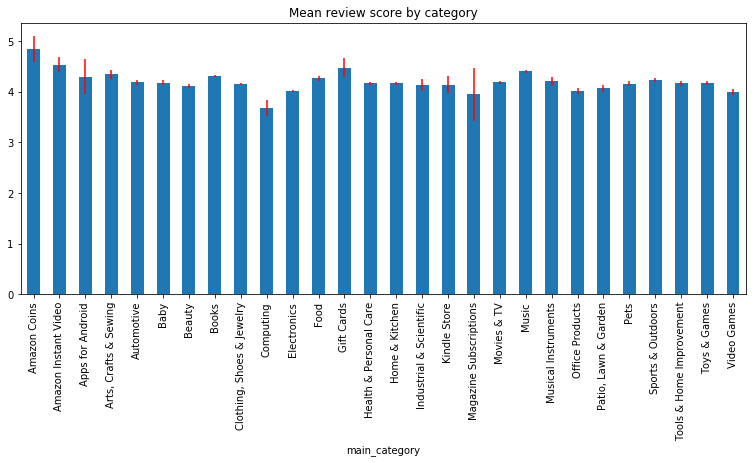

In [30]:
_, ax = plt.subplots(figsize=(13,5))
by_category = joined.groupby('main_category')

ax.set_title('Mean review score by category')

plot_groupby_error_bars(by_category.overall, 1000, np.mean, ax)

We can see from here that products belonging to certain categories indeed tend to receive better reviews on average.

We can also look at the relationship between the overall rating given in a review and the overall sentiment score of the description. We expect negative reviews to have a sentiment score closer to -1 and vice versa. The sentiment classifier we chose assigns 4 scores to each review text: positive score, negative score, neutral score and a normalized compound score. Negative, positive and neutral scores go from 0 to 1 and compound score goes from -1 (most negative) to 1 (most positive) where scores between -0.5 and 0.5 are considered neutral.

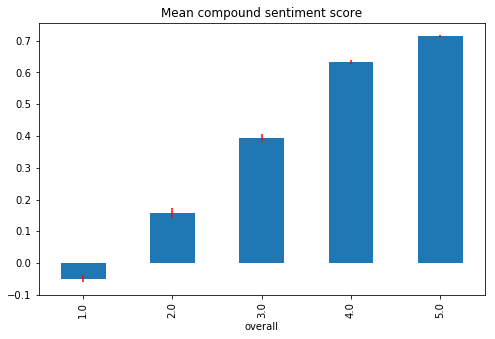

In [31]:
by_overall = joined.groupby('overall')

_, ax = plt.subplots(figsize=(8,5))
ax.set_title('Mean compound sentiment score')
plot_groupby_error_bars(by_overall.compound_score, 1000, np.mean, ax)

Our expectations were correct: negative reviews indeed have a lower sentiment score, but even the 1 star reviews do not seem to have a strongly negative connotation. Perhaps overly rude or angry reviews are removed by Amazon's staff.

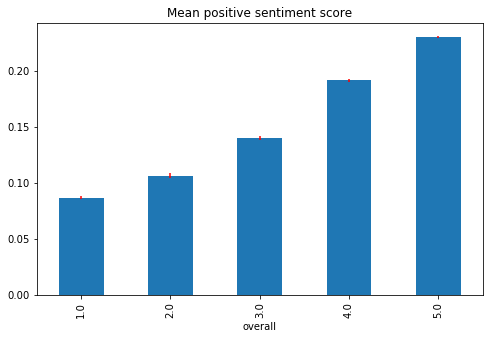

In [32]:
_, ax = plt.subplots(figsize=(8,5))
ax.set_title('Mean positive sentiment score')

plot_groupby_error_bars(by_overall.positive_score, 1000, np.mean, ax)

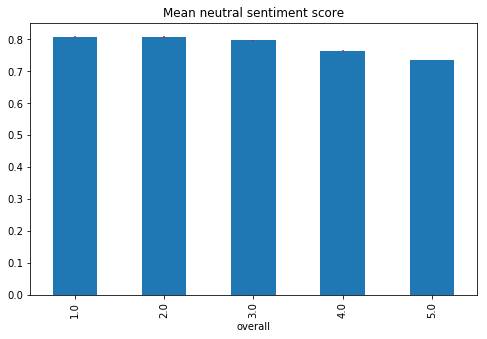

In [33]:
_, ax = plt.subplots(figsize=(8,5))
ax.set_title('Mean neutral sentiment score')

plot_groupby_error_bars(by_overall.neutral_score, 1000, np.mean, ax)

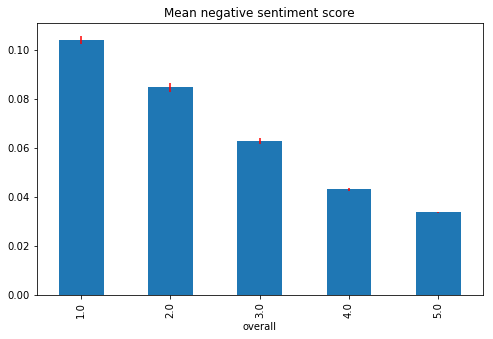

In [34]:
_, ax = plt.subplots(figsize=(8,5))
ax.set_title('Mean negative sentiment score')

plot_groupby_error_bars(by_overall.negative_score, 1000, np.mean, ax)

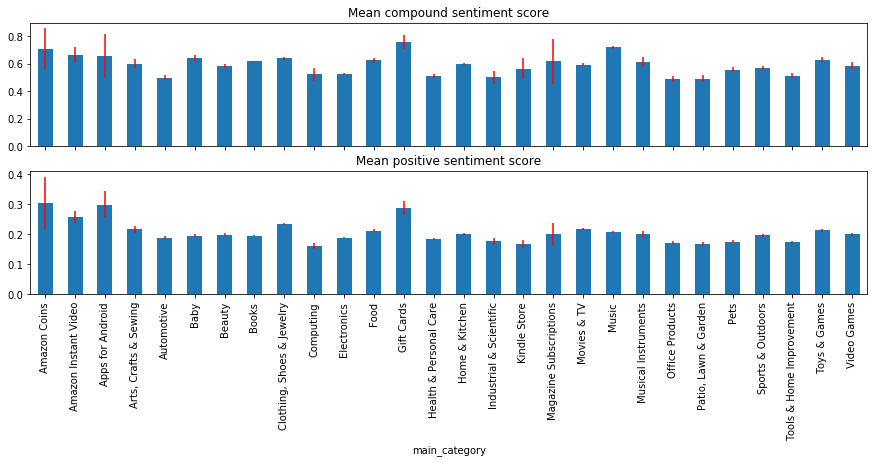

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 5))
ax1.set_title('Mean compound sentiment score')
plot_groupby_error_bars(by_category.compound_score, 1000, np.mean, ax1)

ax2.set_title('Mean positive sentiment score')
plot_groupby_error_bars(by_category.positive_score, 1000, np.mean, ax2)

The negative, positive and neutral sentiment scores confirm what we saw by observing the compound score. Like with ratings, some categories such as gift cards, music, baby, toys and games have a higher compound or positive semtiment score even though none of them is very different from the others. Gift cards also has very few reviews so its score is not reliable.

We verify whether an item's price is correlated to its sentiment score.

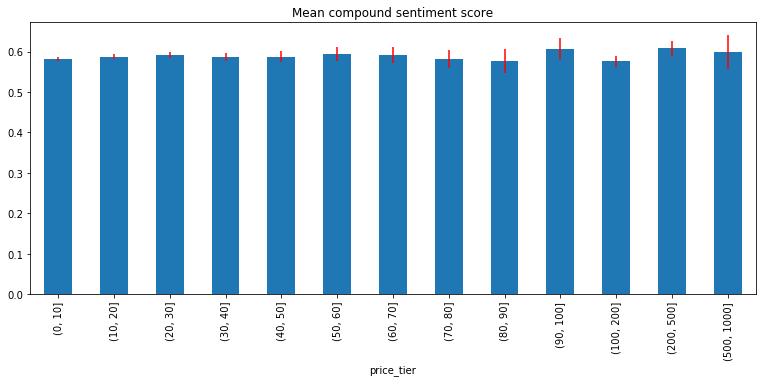

In [36]:
fig, ax = plt.subplots(figsize=(13, 5))
ax.set_title('Mean compound sentiment score')
plot_groupby_error_bars(group_by_price_tier.compound_score, 1000, np.mean, ax)

A more positive sentiment score doesn't correlate with a higher price.

We tried to verify whether the sentiment score of the reviews of a product correlates with its sales ranking

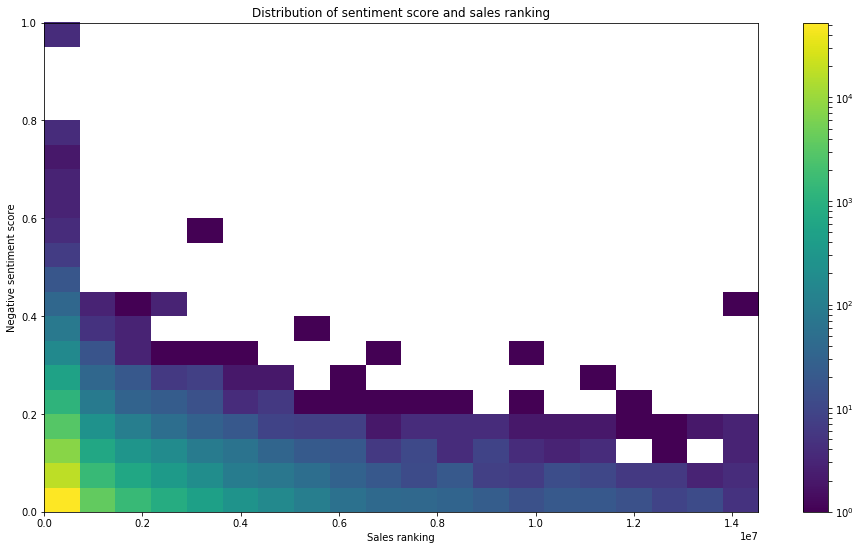

In [37]:
fig, ax = plt.subplots(figsize=(16, 9))
onlyranked = joined.dropna(subset=['salesRankPosition'])

r = ax.hist2d(onlyranked.salesRankPosition, onlyranked.negative_score, bins=20, norm=LogNorm())
ax.set_title('Distribution of sentiment score and sales ranking')
ax.set_xlabel('Sales ranking')
ax.set_ylabel('Negative sentiment score')
fig.colorbar(r[3])

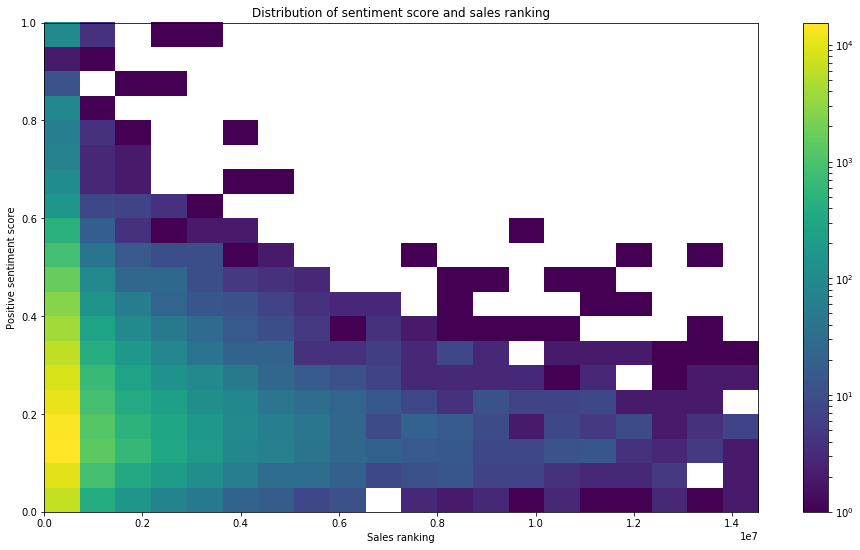

In [38]:
fig, ax = plt.subplots(figsize=(16, 9))
img = ax.hist2d(onlyranked.salesRankPosition, onlyranked.positive_score, bins=20, norm=LogNorm())
ax.set_title('Distribution of sentiment score and sales ranking')
ax.set_xlabel('Sales ranking')
ax.set_ylabel('Positive sentiment score')
fig.colorbar(img[3])

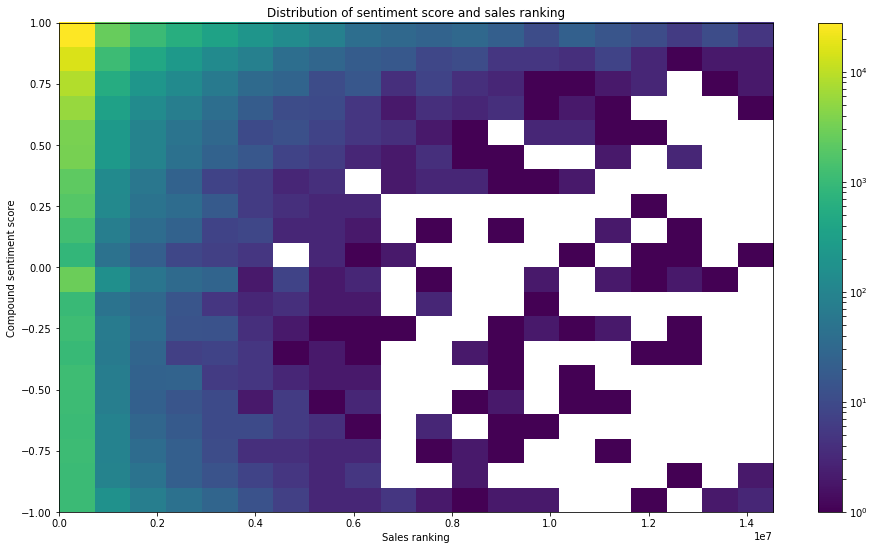

In [39]:
fig, ax = plt.subplots(figsize=(16, 9))
img = ax.hist2d(onlyranked.salesRankPosition, onlyranked.compound_score, bins=20, norm=LogNorm())
ax.set_title('Distribution of sentiment score and sales ranking')
ax.set_xlabel('Sales ranking')
ax.set_ylabel('Compound sentiment score')
fig.colorbar(img[3])

The sales ranking of a product and the sentiment score of its reviews don't seem to be correlated: from the above plots we can see that the items that have the most reviews are those higher up in the sales ranking which is expected since they are more likely to appear in user searches but also that the overall distribution of the sentiment scores doesn't change with the sales ranking.

We tried comparing the length of the reviews to the price tier of the items being reviewed: our theory is that customers that purchase a more expensive item are more likely to write a more detailed review. We observed that this doesn not happen when looking at the dataset as a whole but only when looking at some categories, such as electronics individually.

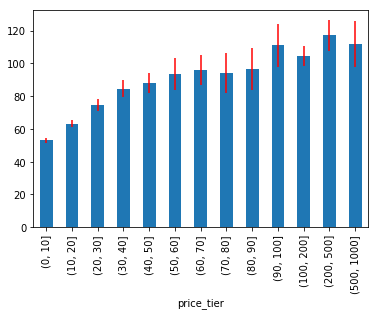

In [40]:
gb = joined[joined.main_category == 'Electronics'].groupby('price_tier').word_count
ax = plt.subplot()
plot_groupby_error_bars(gb, 1000, np.mean, ax)

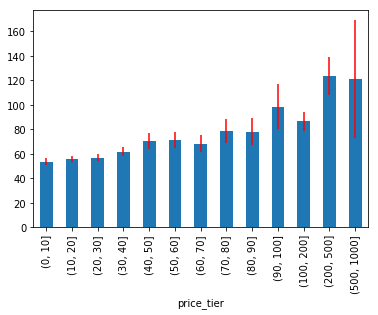

In [41]:
gb = joined[joined.main_category == 'Home & Kitchen'].groupby('price_tier').word_count
ax = plt.subplot()
plot_groupby_error_bars(gb, 1000, np.mean, ax)

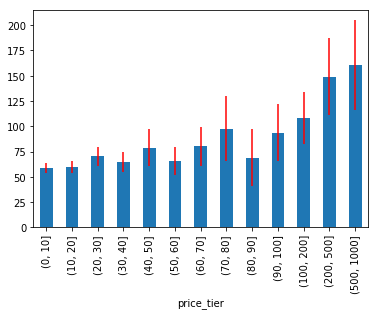

In [42]:
gb = joined[joined.main_category == 'Office Products'].groupby('price_tier').word_count
ax = plt.subplot()
plot_groupby_error_bars(gb, 1000, np.mean, ax)

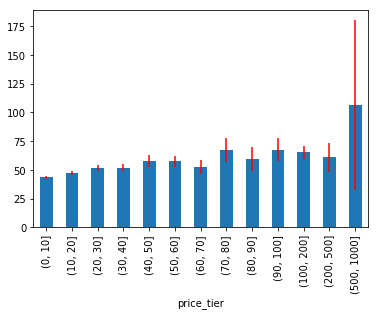

In [43]:
gb = joined[joined.main_category == 'Clothing, Shoes & Jewelry'].groupby('price_tier').word_count
ax = plt.subplot()
plot_groupby_error_bars(gb, 1000, np.mean, ax)

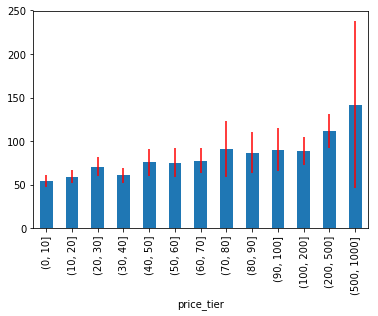

In [44]:
gb = joined[joined.main_category == 'Patio, Lawn & Garden'].groupby('price_tier').word_count
ax = plt.subplot()
plot_groupby_error_bars(gb, 1000, np.mean, ax)

### Observations
In the abstract for our project we planned to investigate whether factors such as a product's price or the season in which a review is written can affect the score given to a product. When analyzing the dataset we found that such correlations seem to be absent in the data and the only other feature that correlates with the review's score is the sentiment score (positive or negative) that the review's extended summary expresses. Furthermore we have discovered that in some of the categories the length of the review positively correlates with the price tier of the product, suggesting that users might write more detailed reviews for products that they spent more money on. It seems that just looking at the numbers in the data doesn't tell us too much about what we want to know and we might need to conduct further analysis on the text of the reviews or the features of the product (such as looking at what other items are related to the one being reviewed or seeing if we can predict whether a review is going to be more useful according to which words the author uses and how high the sentimental score of the review is. 

### Future Direction:

We struggled to find significant correlations with the price, time, salesRank factors on user reviews, as we had initially proposed. However, we became more interested in learning about how incentivization can impact how reviewers write their reviews and how products are rated. The following is a glimpse into a couple interesting leads we have to understand the influence of incentivization on review quality.

In [45]:
joined.shape


(125958, 33)

In [46]:
# Using keywords in incentivized reviews (i.e., "I received xxx product for free in exchange for an honest, 
# unbiased review"), we separate the incentivized reviews from those that are not incentivized. 
mask = joined['reviewText'].map(lambda x: ('in exchange for an unbiased review' in x) or ('in exchange for an honest' in x) or ('disclaimer' in x) or ('all opinions stated' in x))
incentivized = joined[mask]
non_incentivized = joined[~mask]

In [47]:
incentivized[incentivized['main_category'] == 'Electronics']

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,brand,categories,description,imUrl,price,related,salesRank,title,reviewMonth,reviewYear,compound_score,positive_score,negative_score,neutral_score,salesRankPosition,salesRankCategory,tokenized_text,word_count,categories_flat,main_category,helpful_pos,helpful_tot,helpful_ratio,price_tier
30849,B00HVORMGI,"[1, 2]",4.0,As a disclaimer I have received a free sample ...,2014-05-02,A1BNXL3N6IMNBL,DB,Freedom!,1398988800,NaN,"[[Cell Phones & Accessories, Accessories, Batt...",Ultra Portable Power &amp; ProtectionGet the e...,http://ecx.images-amazon.com/images/I/41b%2Bsz...,49.95,"{'also_bought': ['B00DDAWL4W', 'B00JS7UFH4', '...",{'Cell Phones & Accessories': 5381},Maxboost Atomic S External Protective iPhone 5...,5,2014,0.0146,0.065,0.065,0.870,5381.0,Cell Phones & Accessories,"[As, a, disclaimer, I, have, received, a, free...",168,"[Cell Phones & Accessories, Accessories, Batte...",Electronics,1,2,0.500000,"(40, 50]"
48307,B009P2FIQA,"[0, 0]",4.0,The back is exactly what I paid for. No blemis...,2014-03-22,A13N4DOFYM9JIX,Josh,Strong 4 stars,1395446400,NaN,"[[Cell Phones & Accessories, Accessories, Acce...",Fashionable and attractive design for your iPh...,http://ecx.images-amazon.com/images/I/51GmdU8k...,13.59,"{'also_bought': ['B0091V0EFK', 'B007V7XOSK', '...",{'Cell Phones & Accessories': 493307},Matek: luxury Diamond Bag Handmade Bling Cryst...,3,2014,-0.2960,0.172,0.241,0.587,493307.0,Cell Phones & Accessories,"[The, back, is, exactly, what, I, paid, for, N...",35,"[Cell Phones & Accessories, Accessories, Acces...",Electronics,0,0,NaN,"(10, 20]"
48588,B00A70MP88,"[0, 0]",4.0,"Overall, I like this case very much.DISCLAIMER...",2013-07-10,A1F7BIPFN9GWVN,Sydney A.,"Not an Otterbox, but fine for casual use",1373414400,NaN,"[[Cell Phones & Accessories, Cases, Basic Cases]]",We believe great products are made greater by ...,http://ecx.images-amazon.com/images/I/41IUlyTR...,8.99,"{'also_bought': ['B008AST7R6', 'B0042FV2SI', '...",{'Cell Phones & Accessories': 2022},[Drop Protection] Caseology Apple iPhone 4 / 4...,7,2013,0.9979,0.209,0.064,0.728,2022.0,Cell Phones & Accessories,"[Overall, I, like, this, case, very, much, DIS...",530,"[Cell Phones & Accessories, Cases, Basic Cases]",Electronics,0,0,NaN,"(0, 10]"
121497,B0092KRAVQ,"[8, 9]",5.0,** NOTE: I received a free package of this pro...,2014-06-18,A1BXVZSQOJE6UE,Ctwink,Another Exceptional Electronics Product From T...,1403049600,NaN,"[[Electronics, Computers & Accessories, Cables...",CONTENTS - In The Friendly Swede retail packag...,http://ecx.images-amazon.com/images/I/51AoPv4F...,10.99,"{'also_bought': ['B00CEURAWA', 'B00GZFUNRE', '...",{'Cell Phones & Accessories': 37449},Bundle of 3PCS Premium Branded 5.5&quot; Thin-...,6,2014,0.9984,0.183,0.010,0.807,37449.0,Cell Phones & Accessories,"[NOTE, I, received, a, free, package, of, this...",516,"[Electronics, Computers & Accessories, Cables ...",Electronics,8,9,0.888889,"(10, 20]"
137602,B001AZP6O4,"[6, 14]",1.0,We purchased this Item to be able to remote lo...,2011-07-19,A1E420DFHY2VT5,Clydesubs,Misleading Advetising and bad support,1311033600,ZyXEL,"[[Electronics, Security & Surveillance, Survei...",,http://ecx.images-amazon.com/images/I/41Gz9unL...,365.99,"{'also_bought': ['B004EIFCHK', 'B004D3QOPA', '...",{},ZyXEL ZyWALL USG100 Unified Security Gateway F...,7,2011,0.9210,0.104,0.035,0.862,NaN,NaN,"[We, purchased, this, Item, to, be, able, to, ...",200,"[Electronics, Security & Surveillance, Surveil...",Electronics,6,14,0.428571,"(200, 500]"
152241,B00G2FD4M8,"[6, 6]",5.0,Let's be honest. Apple products get all the go...,2014-02-19,A1G650TTTHEAL5,"Charles Spanky ""Zumina Reviews""",If you want to use your android device as an a...,1392768000,Hale Devices Inc,"[[Electronics, Portable Audio & Video]]",,http://ecx.images-amazon.com/images/I/41yL3Slx...,79.99,"{'also_bought': ['B00GND21H8', 'B00J0825JC', '...",NaN,Hale Dreamer Alarm Clock Spea

In [48]:
# This is an example of a so-called "unbiased review"
print('Incentivized Review example: ')
incentivized.iloc[100]['reviewText']

Incentivized Review example: 


"Kregel Publications has come out with a revised version of their Candle Bible Handbook this past March.  If you are looking for a Bible Study tool for your kids to go along with their Bible devotional books, this would be a great addition to your library.  This book is for children ages 8-12 years old.  This Bible handbook gives an overall view of how the Bible is organized into different categories (History, Poetry, Major and Minor Prophets, etc.).  Then, an overview of the Old Testament is given along with a timeline of major events.  Following this overview, the handbook gives information on each book of the Bible by including FAQ, an outline, maps and concludes with study questions.  The New Testament does the same thing, but also includes a section on the life of Christ.  After all the books of the Bible have been discussed, the book concludes with several different sections: Big Ideas in the Bible, Promises Made in the Bible, 50 Very Important Passages, and Who's Who in the Bibl

In [49]:
# Sizes of incentivized samples vs non.
print(non_incentivized.shape)
print(incentivized.shape)

(125816, 33)
(142, 33)


In [50]:
print("incentivized overall rating: ", incentivized['overall'].mean())
print("non_incentivized overall rating: ", non_incentivized['overall'].mean())

incentivized overall rating:  4.28873239437
non_incentivized overall rating:  4.1889346347


Frequency of Star Ratings of Incentivized Reviews


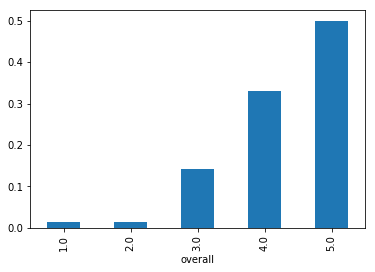

Histogram of Review Text Sentiment Scores for Incentivized Reviews


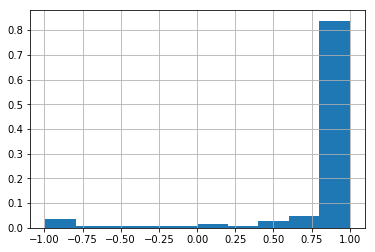

Frequency of Star Ratings of Non-Incentivized Reviews


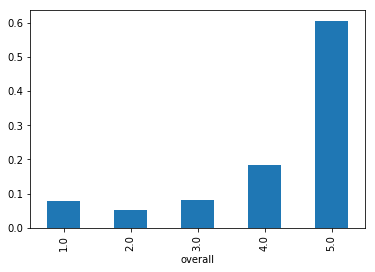

Histogram of Review Text Sentiment Score for Non-Incentivized Reviews


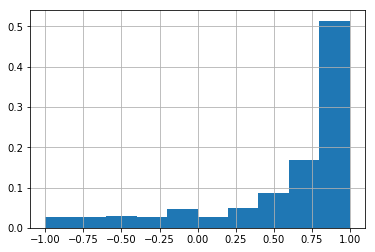

In [51]:
print('Frequency of Star Ratings of Incentivized Reviews')
(incentivized.groupby('overall').size()/incentivized.shape[0]).plot(kind = 'bar')
plt.show()
print('Histogram of Review Text Sentiment Scores for Incentivized Reviews')
incentivized['compound_score'].hist(weights = [1/incentivized.shape[0]]*incentivized.shape[0])
plt.show()
print('Frequency of Star Ratings of Non-Incentivized Reviews')

(non_incentivized.groupby('overall').size()/non_incentivized.shape[0]).plot(kind = 'bar')
plt.show()
print('Histogram of Review Text Sentiment Score for Non-Incentivized Reviews')

non_incentivized['compound_score'].hist(weights = [1/non_incentivized.shape[0]]*non_incentivized.shape[0])
plt.show()

Although, the sizes of the two sets of reviews is very different, and we do not have nearly as many for the incentivized set compared to the non-incentivized set, we can still make some conclusions on how people, who are given products for free or at a discount, write their reviews. Using the vader sentiment analyzer, we can see that incentivized reviews are much more positive that non-incentivized. In addition, people who are given products for free/discounted give more positive ratings and less 1 or 2-star ratings. Our plan to further analyze this phenomenon is detailed in the readme.

In [52]:
incentivized.word_count.describe()

count     142.000000
mean      331.471831
std       270.700266
min        35.000000
25%       177.000000
50%       274.000000
75%       373.750000
max      1967.000000
Name: word_count, dtype: float64

In [53]:
non_incentivized.word_count.describe()

count    125816.000000
mean         86.399130
std         118.613081
min           0.000000
25%          27.000000
50%          47.000000
75%          95.000000
max        4837.000000
Name: word_count, dtype: float64

Histogram of Review Text compound Sentiment Scores


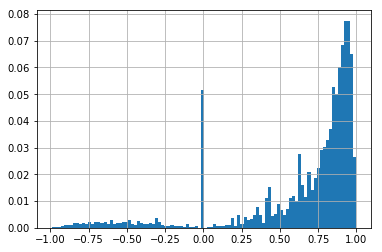

Histogram of Review Text positive Sentiment Scores


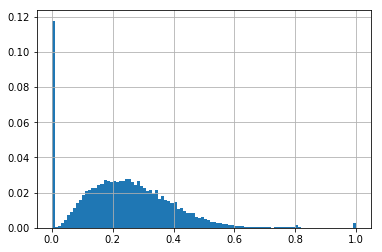

Histogram of Review Text negative Sentiment Scores


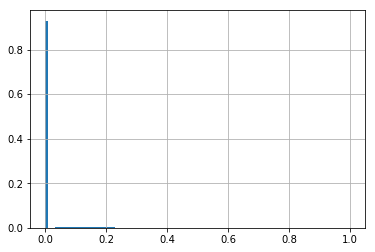

Histogram of Review Text neutral Sentiment Scores


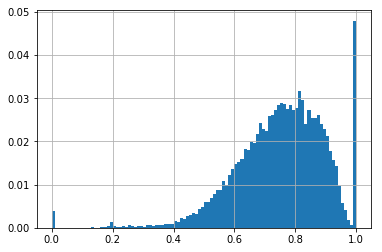

In [54]:

no_zero = joined[(joined['positive_score'] == 0.0) | (joined['compound_score'] == 0.0) | (joined['negative_score'] == 0.0) | (joined['neutral_score'] == 0.0)]

print('Histogram of Review Text compound Sentiment Scores')
no_zero['compound_score'].hist(weights = [1/no_zero.shape[0]]*no_zero.shape[0], bins = 100)
plt.show()

print('Histogram of Review Text positive Sentiment Scores')
no_zero['positive_score'].hist(weights = [1/no_zero.shape[0]]*no_zero.shape[0], bins = 100)
plt.show()

print('Histogram of Review Text negative Sentiment Scores')
no_zero['negative_score'].hist(weights = [1/no_zero.shape[0]]*no_zero.shape[0], bins = 100)
plt.show()

print('Histogram of Review Text neutral Sentiment Scores')
no_zero['neutral_score'].hist(weights = [1/no_zero.shape[0]]*no_zero.shape[0], bins = 100)
plt.show()

In [55]:
joined.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,brand,categories,description,imUrl,price,related,salesRank,title,reviewMonth,reviewYear,compound_score,positive_score,negative_score,neutral_score,salesRankPosition,salesRankCategory,tokenized_text,word_count,categories_flat,main_category,helpful_pos,helpful_tot,helpful_ratio,price_tier
2,B00E7OIOVC,"[0, 0]",5.0,Great!,2014-07-03,A0001528BGUBOEVR6T5U,igozingo,Five Stars,1404345600,niceEshop,"[[Home & Kitchen, Kitchen & Dining, Kitchen Ut...",Style flask funnel great to help you fill your...,http://ecx.images-amazon.com/images/I/31gMKQdA...,1.99,"{'also_bought': ['B004TQIB7U', 'B006O1EBHW', '...",{'Kitchen & Dining': 63021},niceEshop(TM) Small Stainless Steel Funnel For...,7,2014,0.6588,1.000,0.000,0.000,63021.0,Kitchen & Dining,[Great],1,"[Home & Kitchen, Kitchen & Dining, Kitchen Ute...",Home & Kitchen,0,0,NaN,"(0, 10]"
3,B00EXOZ9W8,"[0, 0]",5.0,"My man was more then happy with it, looking fo...",2014-07-02,A00030342K9JCQO8Q7C3L,Joseph Dvorak,Five Stars,1404259200,NaN,"[[Home & Kitchen, Kitchen & Dining, Small Appl...",,http://ecx.images-amazon.com/images/I/41Oc0HaP...,65.81,"{'also_bought': ['B000FAJ0K6', 'B0012UY6XO', '...",{'Kitchen & Dining': 56153},BELLA 14025 Programmable Slow Cooker with Lock...,7,2014,0.7893,0.349,0.000,0.651,56153.0,Kitchen & Dining,"[My, man, was, more, then, happy, with, it, lo...",14,"[Home & Kitchen, Kitchen & Dining, Small Appli...",Home & Kitchen,0,0,NaN,"(60, 70]"
4,1477473939,"[0, 0]",4.0,Reading this seriers was a amazing. It was ver...,2013-01-26,A000443821AD43TOGKNGZ,Uluwehi,Really enjoyed it!,1359158400,NaN,[[Books]],USA Today Best Selling Author Elizabeth Reyes...,http://ecx.images-amazon.com/images/I/51bhuPCO...,4.99,"{'also_bought': ['147522186X', '1475244207', '...",{'Books': 1011147},Making You Mine: The Moreno Brothers,1,2013,0.9199,0.353,0.000,0.647,1011147.0,Books,"[Reading, this, seriers, was, a, amazing, It, ...",31,[Books],Books,0,0,NaN,"(0, 10]"
5,1477473939,"[0, 0]",4.0,"I haven't read any of this series before, but ...",2013-04-09,A1BAWRQQMC7L72,Roswellfan410,Really liked it,1365465600,NaN,[[Books]],USA Today Best Selling Author Elizabeth Reyes...,http://ecx.images-amazon.com/images/I/51bhuPCO...,4.99,"{'also_bought': ['147522186X', '1475244207', '...",{'Books': 1011147},Making You Mine: The Moreno Brothers,4,2013,0.9548,0.411,0.000,0.589,1011147.0,Books,"[I, haven, t, read, any, of, this, series, bef...",35,[Books],Books,0,0,NaN,"(0, 10]"
6,B0092QSQ3Q,"[0, 0]",5.0,It is really good! But it was hard to push out...,2012-11-03,A00044782UB564I4SGA0X,Johan98,Really good!,1351900800,NaN,"[[Cell Phones & Accessories, Accessories, Scre...",Protect your InvestmentDaily use of your mobil...,http://ecx.images-amazon.com/images/I/51722Hcw...,5.95,"{'also_bought': ['B00FDXLRM4', 'B009VO0506', '...",{'Cell Phones & Accessories': 4377},Skinomi&reg; TechSkin - Apple iPhone 5 Screen ...,11,2012,0.6534,0.228,0.056,0.716,4377.0,Cell Phones & Accessories,"[It, is, really, good, But, it, was, hard, to,...",22,"[Cell Phones & Accessories, Accessories, Scree...",Electronics,0,0,NaN,"(0, 10]"


In [56]:
# bucket the reviews, tf-idf

In [57]:
joined.groupby('overall').tokenized_text.sum()

KeyboardInterrupt: 